In [1]:
from collections import defaultdict
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from Bio import SeqIO, SearchIO, Entrez
import subprocess as sp
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import os, glob, math, re, gzip, pysam, itertools, skbio, time
from concurrent.futures import ProcessPoolExecutor
from statsmodels.stats.multitest import multipletests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [3]:
rootdir = "/scratch/users/ajaffe/deepeco/"
cmdir(rootdir + "txomics")

## compute

In [4]:
cmdir(rootdir + "txomics/mapping")

### read in non-redundant data

In [5]:
nr_genomes = pd.read_csv(rootdir + "tables/nonredundant_genome_info.tsv", sep="\t")
nr_genomes.head()

,genome,classification,checkm_completeness,checkm_redundancy,primary_cluster,secondary_cluster,representative,scluster_rubisco_set,phylum
0,OceanDNA-b21631,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,82.99,2.48,1,1_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria
1,OceanDNA-b21628,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,79.21,2.09,3,3_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria
2,TARA_SAMEA4397330_METAG_GFBBFFPE,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,88.16,1.10,4,4_1,True,II_II,d__Bacteria_p__Proteobacteria
3,GCA_030739585.1_ASM3073958v1_genomic,d__Archaea;p__Thermoproteota;c__Bathyarchaeia;...,93.93,1.87,5,5_1,True,III_B,d__Archaea_p__Thermoproteota
4,OceanDNA-b35769,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,95.16,0.59,6,6_1,True,I,d__Bacteria_p__Proteobacteria


In [146]:
# metabolisms
pathways = pd.read_csv(rootdir + "tables/metabolic_pathway_info.tsv", sep="\t")
pathways.head(2)

,function,genome_name,hit_count,hit_total,hit_perc,hit_kos,hit_ids,count_threshold
0,Aerobic Hydrogen Oxidation,MARD_SAMEA2272692_REFG_MMP2272692,1,1,100.0,"NiFe hydrogenase (1d, 1l, 2a)",MARD_MMP2272692_REFG-scaffold_10_10,1
1,Aerobic Hydrogen Oxidation,MARD_SAMEA3214536_REFG_MMP3214536,1,1,100.0,"NiFe hydrogenase (1d, 1l, 2a)",MARD_MMP3214536_REFG-scaffold_171_4,1


### prep genomes

In [ ]:
# create fasta, genes, stb for nr db
fasta = open(rootdir + "txomics/nonredundant_genomes.fna", "w")
stb = open(rootdir + "txomics/nonredundant_genomes.stb", "w")

for key, row in nr_genomes.iterrows():
    
    # locate the file
    gpath = rootdir + "genomes/first_pass/%s.fa" %(row["genome"])
    
    # write merged fasta and stb
    for record in sfp(open(gpath)):
        fasta.write(">%s\n%s\n" %(record[0].split(" ")[0], record[1]))
        stb.write("%s\t%s\n" %(record[0].split(" ")[0], row["genome"]))

fasta.close()
stb.close()

In [ ]:
# create bowtie idx
cmd = "bowtie2-build %s %s" %(rootdir + "txomics/nonredundant_genomes.fna", \
                              rootdir + "txomics/mapping/nr_genomes.idx")
print(cmd)

In [ ]:
# write to snakefile config
with open(rootdir + "txomics/mapping/config.yaml", "w") as out:
    
    out.write("fasta: %s\n" %(rootdir + "txomics/nonredundant_genomes.fna"))
    out.write("stbfile: %s\n" %(rootdir + "txomics/nonredundant_genomes.stb"))
    out.write("idx: %s\n" %(rootdir + "txomics/mapping/nr_genomes.idx"))

### get input data - major cruises

In [5]:
Entrez.email = "ajaffe@stanford.edu"

In [12]:
def retrieve_depth(biosample):
    
    try:
        # get biosam_id
        handle = Entrez.esearch(db='biosample', term=biosample + ' AND "biosample sra"[filter]', RetMax=10)
        soup = BeautifulSoup(handle, "html.parser")
        biosam = [item.string for item in soup.find("id")]

        handle.close()
        # query biosample with that id
        handle = Entrez.efetch(db="biosample", id=biosam, rettype="summary", retmode="xml")
        soup = BeautifulSoup(handle, "html.parser")
        handle.close() 
    except:
        print("%s failed." %(biosample))
        return "None"
    
    attrs = {}
    for attribute in soup.findAll("attribute"):
        attrs[attribute["attribute_name"]] = attribute.string

    for field in ['depth']:
        if field in attrs.keys():
            return(attrs[field])
        else: return "None"

In [15]:
# full sample table - tara
omd_metadata = pd.read_csv(rootdir + "tables/omd_tara_metat.csv")
depths = [retrieve_depth(item) for item in omd_metadata["sample_accessions"]]
omd_metadata["depth"] = depths
omd_metadata.head()

SAMEA2620136,SAMEA2620147,SAMEA2620158,SAMEA2620169 failed.
SAMEA2621041 failed.
SAMEA2623734,SAMEA2623735 failed.
SAMEA2623808,SAMEA2623809 failed.
SAMEA2623850,SAMEA2623851 failed.
SAMEA2623925,SAMEA2623929,SAMEA2623931 failed.
SAMEA2623974,SAMEA2624000 failed.


,sample_name,internal_sample_name,sample_material,study_accessions,sample_accessions,run_accessions,internal_run_accessions,depth
0,TARA_SAMEA3905024_METAT,TARA_011_SRF_0.22-1.6_T,TARA_011_SRF_0.22-1.6,PRJEB6608,SAMEA3905024,"ERR1336912,ERR1336911","BEZ_ADGAOSW_3_C7BWPACXX.IND3_noribo_clean,BEZ_...",5
1,TARA_SAMEA2619639_METAT,TARA_015_SRF_0.22-1.6_T,TARA_015_SRF_0.22-1.6,PRJEB6608,SAMEA2619639,"ERR3586985,ERR3587078","BEZ_ADHAOSW_1_C8D3YACXX.IND5_noribo_clean,BEZ_...",5
2,TARA_SAMEA2619647_METAT,TARA_016_SRF_0.22-1.6_T,TARA_016_SRF_0.22-1.6,PRJEB6608,SAMEA2619647,"ERR3586986,ERR3587079","BEZ_ADIAOSW_2_C8D3YACXX.IND11_noribo_clean,BEZ...",5
3,TARA_SAMEA2619669_METAT,TARA_018_SRF_0.22-1.6_T,TARA_018_SRF_0.22-1.6,PRJEB6608,SAMEA2619669,"ERR3586987,ERR3587080","BEZ_ADKAOSW_3_C8D3YACXX.IND12_noribo_clean,BEZ...",5
4,TARA_SAMEA2619691_METAT,TARA_019_SRF_0.22-1.6_T,TARA_019_SRF_0.22-1.6,PRJEB6608,SAMEA2619691,"ERR3586988,ERR3587081","BEZ_ADLAOSW_4_C8D3YACXX.IND1_noribo_clean,BEZ_...",5


In [ ]:
with open(rootdir + "txomics/mapping/sample_list.tsv", "w") as out:
    for key, row in omd_metadata.iterrows():
        out.write("%s\t%s\n" %(row["sample_name"], row["run_accessions"]))

### various omz studies

In [17]:
query = 'PRJNA263621 OR PRJNA407229 OR PRJNA277357 OR PRJNA306182'
handle = Entrez.esearch(db='sra', term=query, RetMax=20000)
# parse the handle
soup = BeautifulSoup(handle, "html.parser")
handle.close()
# then grab the uIds
sra_ids = [item.string for item in soup.findAll("id")]
len(sra_ids)

67

In [18]:
results = defaultdict(list)

for i,sra_id in enumerate(sra_ids):
    
    try:
        handle = Entrez.efetch(db="sra", id=sra_id, rettype="runinfo", retmode="xml")
        soup = BeautifulSoup(handle, "html.parser")
        handle.close()
    except:
        print("%s failed." %(sra_id))
        continue

    for row in soup.findAll("row"):
        for attribute in ["bases","bioproject", "biosample", "experiment", "run", "libraryname", "samplename",
                          "scientificname", "releasedate", "spots",  
                        "avglength", "librarystrategy", "librarysource", "librarylayout","platform"]:
            try:
                results[attribute].append(row.find(attribute).string)
            except: results[attribute].append("None")
    
    print("%d of %d done." %(i+1, len(sra_ids)), end = "\r")

In [19]:
resultdf = pd.DataFrame(results).query("librarysource=='METATRANSCRIPTOMIC'")
resultdf["depth"] = resultdf["samplename"].apply(lambda x: x.split("_")[-1].strip("m") if \
                                                  x.startswith("ETNP") else x.split("_")[0].strip("m"))

#with open(rootdir + "txomics/mapping/sample_list.tsv", "a") as out:
#    for key, row in resultdf.iterrows():
#        out.write("%s\t%s\n" %(row["samplename"].replace(">",""), row["run"]))

### run + check

Move snakefile from local into `/mapping`, with instrain step removed.

In [ ]:
cmd = 'snakemake --keep-going -s RNASnakefile \
      --config sample_list=%s genome_table=%s maxthreads=20 \
      --cluster "sbatch -p serc -c 20 -t 1- --mem 160G" --jobs 25' %(rootdir + "txomics/mapping/sample_list.tsv",
                                                                     rootdir + "tables/nonredundant_genome_info.tsv")
print(cmd)

In [ ]:
attempted = list(omd_metadata["sample_name"]) + list(resultdf["samplename"])
succeeded = glob.glob(rootdir + "txomics/mapping/output/*tsv")

print("%d of %d samples successfully mapped." %(len(succeeded), len(attempted)))

## process

### filter

In [ ]:
def filter_sample(output_file):
    
    start=time.time()
    filtered_results = []
    sample_table = pd.read_csv(output_file, sep="\t")
    
    for genome in sample_table["genome"].unique():
        
        subtable = sample_table[sample_table["genome"]==genome]
        
        # min gene expressed threshold
        if len(subtable.query("breadth>0.50"))>=50:
        
            # then remove high outliers
            genes_to_remove = []
            counts = subtable["mean_coverage"].to_list()
            median = np.median([count for count in counts if count != 0])

            for i, count in enumerate(counts):
                if count > (median*10000):
                    genes_to_remove.append(subtable["gene"].to_list()[i])
            
            filtered_results.append(subtable[~subtable["gene"].isin(genes_to_remove)])
            
    end = time.time()
    print("%s finished in %f seconds." %(os.path.basename(output_file), end-start))
    
    if len(filtered_results) > 0:
        return pd.concat(filtered_results)
    else: return "None"

In [ ]:
%%time

with ProcessPoolExecutor(10) as executor:
    samples = glob.glob(rootdir + "txomics/mapping/output/*tsv")
    results = list(executor.map(filter_sample, samples))

all_results = pd.concat([result for result in results if type(result) != str])
all_results = all_results[["sample", "genome", "gene", "mean_coverage", "breadth", "read_count"]]
#all_results.to_csv(rootdir + "tables/filtered_txome_output.tsv", sep="\t")

In [ ]:
cmd = "rclone copy %s drive:deepeco/tables" %(rootdir + "tables/filtered_txome_output.tsv")
print(cmd)

### calculate rpkm

In [6]:
all_results = pd.read_csv(rootdir + "tables/filtered_txome_output.tsv", sep="\t")

In [7]:
tmp = {}

for key, row in nr_genomes.iterrows():
    gpath = rootdir + "genomes/prodigal/%s.genes.fna" %(row["genome"])
    for record in sfp(open(gpath)):
        tmp[record[0].split(" ")[0]] = len(record[1])

all_results["gene_length"] = all_results["gene"].map(tmp)
tmp={}

In [8]:
tmp = {}

for sample in glob.glob(rootdir + "txomics/mapping/trimmed_reads/counts/*"):
    for line in open(sample).readlines():
        tmp[line.split("\t")[0]] = int(line.split("\t")[1].strip())

all_results["total_read_count"] = all_results["sample"].map(tmp)
tmp = {}

In [9]:
# consider rewriting this in dask
all_results["rpk"] = all_results.apply(lambda x: (x["read_count"]*2)/(x["gene_length"]/1000), axis=1)
all_results["rpkm"] = all_results.apply(lambda x: x["rpk"]/(x["total_read_count"]/1e6), axis=1)
all_results.head(2)

,Unnamed: 0,sample,genome,gene,mean_coverage,breadth,read_count,gene_length,total_read_count,rpk,rpkm
0,306706,TARA_SAMEA2623830_METAT,AG-333-E20,CABYJX010000001.1_1,0.05,0.053680,1,1155,315435310,1.731602,0.005490
1,306707,TARA_SAMEA2623830_METAT,AG-333-E20,CABYJX010000001.1_2,0.42,0.230159,3,882,315435310,6.802721,0.021566


## analyze

### bring back metadata

In [10]:
palette={"I":"#A6D6A6", "I,II_II":"#c9bd75", "II_II":"#E2B2AC", "II_III_II_III":"#ff995c",
         "III_A": "#EDB66E", "III_B": "#EDB66E", "III_C": "#EDB66E", "III_Like": "#EDB66E", "IV":"darkgrey",
         "III_UNK": "darkgrey"}

In [165]:
metat_md = pd.concat([omd_metadata[~omd_metadata["depth"].isin(["None", 
                        "10-100"])][["sample_name", "sample_accessions", "run_accessions", "depth"]].rename(columns={"sample_accessions":"biosample", "run_accessions":"runs"}),
                      resultdf[["samplename", "biosample", "depth", "run"]].rename(columns={"samplename":"sample_name", "run":"runs"})])
metat_md["depth_numeric"] = metat_md["depth"].apply(lambda x: int(x))
deep_samples = metat_md.query("depth_numeric>=200")["sample_name"].to_list()
metat_md.head()

,sample_name,biosample,runs,depth,depth_numeric
0,TARA_SAMEA3905024_METAT,SAMEA3905024,"ERR1336912,ERR1336911",5,5
1,TARA_SAMEA2619639_METAT,SAMEA2619639,"ERR3586985,ERR3587078",5,5
2,TARA_SAMEA2619647_METAT,SAMEA2619647,"ERR3586986,ERR3587079",5,5
3,TARA_SAMEA2619669_METAT,SAMEA2619669,"ERR3586987,ERR3587080",5,5
4,TARA_SAMEA2619691_METAT,SAMEA2619691,"ERR3586988,ERR3587081",5,5


### rubisco specific

In [25]:
rubisco = pd.read_csv(rootdir + "tables/redundant_rubisco_info.tsv", sep="\t")
rmerge = all_results.merge(rubisco[["gene", "curated_rubisco_form"]], how="left", on="gene").fillna("None")
rmerge = rmerge.merge(nr_genomes[["genome", "classification"]], how="left", on="genome")

In [10]:
def compute_percentile(row):
    
    if row["rpkm"] == 0:
        return [row["genome"], row["sample"], row["gene"], 0]
    else:
        distribution = list(all_results[(all_results["genome"]==row["genome"]) &\
                           (all_results["sample"]==row["sample"]) &  (all_results["breadth"]>=0.50)  & \
                            (all_results["gene"]!=row["gene"])]["rpkm"])
        percentile = stats.percentileofscore(distribution, row["rpkm"], kind="rank")
        return [row["genome"], row["sample"], row["gene"], percentile]

In [11]:
with ProcessPoolExecutor(10) as executor:
    rows = [row for key, row in rmerge[(rmerge["curated_rubisco_form"]!='None')].iterrows()]
    results = list(executor.map(compute_percentile, rows))

presults = pd.DataFrame(results, columns=["genome", "sample", "gene", "percentile"])
presults.head()

,genome,sample,gene,percentile
0,AG-333-E20,TARA_SAMEA2623830_METAT,CABYJX010000030.1_9,0.000000
1,TARA_SAMEA2622219_METAG_HPMPIAJL,TARA_SAMEA2623830_METAT,TARA_SAMEA2622219_METAG-scaffold_42861_1,0.000000
2,GORG_SAMEA6069932_SAGS_AG893G21,TARA_SAMEA2623830_METAT,GORG_AG893G21_SAGS-scaffold_1_149,0.000000
3,TARA_SAMEA2619766_METAG_GANBJGDD,TARA_SAMEA2623830_METAT,TARA_SAMEA2619766_METAG-scaffold_3601_3,0.000000
4,GORG_SAMEA6080110_SAGS_AG435J13,TARA_SAMEA2623830_METAT,GORG_AG435J13_SAGS-scaffold_2_74,45.116279


In [12]:
#all_merge = rmerge[(rmerge["curated_rubisco_form"]!='None')].merge(presults, how="left", on=["genome", "sample", "gene"])
#all_merge.to_csv(rootdir + "tables/rubisco_txome_output.tsv", sep="\t")

In [26]:
all_merge = pd.read_csv(rootdir + "tables/rubisco_txome_output.tsv", sep="\t")
all_merge.head()

,Unnamed: 0.1,Unnamed: 0,sample,genome,gene,mean_coverage,breadth,read_count,gene_length,total_read_count,rpk,rpkm,curated_rubisco_form,classification,percentile
0,0,307902,TARA_SAMEA2623830_METAT,AG-333-E20,CABYJX010000030.1_9,0.00,0.000000,0,1455,315435310,0.000000,0.000000,I,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.000000
1,1,310801,TARA_SAMEA2623830_METAT,TARA_SAMEA2622219_METAG_HPMPIAJL,TARA_SAMEA2622219_METAG-scaffold_42861_1,0.00,0.000000,0,1491,315435310,0.000000,0.000000,I,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.000000
2,2,397680,TARA_SAMEA2623830_METAT,GORG_SAMEA6069932_SAGS_AG893G21,GORG_AG893G21_SAGS-scaffold_1_149,0.00,0.000000,0,1194,315435310,0.000000,0.000000,IV,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.000000
3,3,717621,TARA_SAMEA2623830_METAT,TARA_SAMEA2619766_METAG_GANBJGDD,TARA_SAMEA2619766_METAG-scaffold_3601_3,0.00,0.000000,0,1458,315435310,0.000000,0.000000,I,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,0.000000
4,4,719665,TARA_SAMEA2623830_METAT,GORG_SAMEA6080110_SAGS_AG435J13,GORG_AG435J13_SAGS-scaffold_2_74,1.64,0.672154,20,1458,315435310,27.434842,0.086975,I,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,45.116279


### plot general

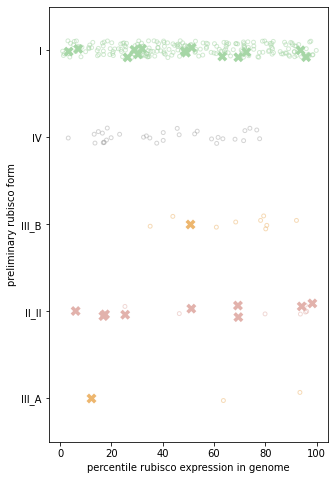

In [27]:
plt.figure(figsize=[5,8])
sns.stripplot(x="percentile",y="curated_rubisco_form", alpha=0.5, hue="curated_rubisco_form",
              palette=palette, size=7.5,
              data=all_merge[(~all_merge["classification"].str.contains("Cyano")) & 
                            (all_merge["breadth"]>=0.50) &
                             (~all_merge["sample"].isin(deep_samples))], marker="$\circ$", ec="face")
sns.stripplot(x="percentile",y="curated_rubisco_form", alpha=1, hue="curated_rubisco_form",
              palette=palette, size=10,
              data=all_merge[(~all_merge["classification"].str.contains("Cyano")) & 
                            (all_merge["breadth"]>=0.50) &
                             (all_merge["sample"].isin(deep_samples))], marker="X")
#plt.xscale("log")
plt.ylabel("preliminary rubisco form")
plt.xlabel("percentile rubisco expression in genome")
plt.show()

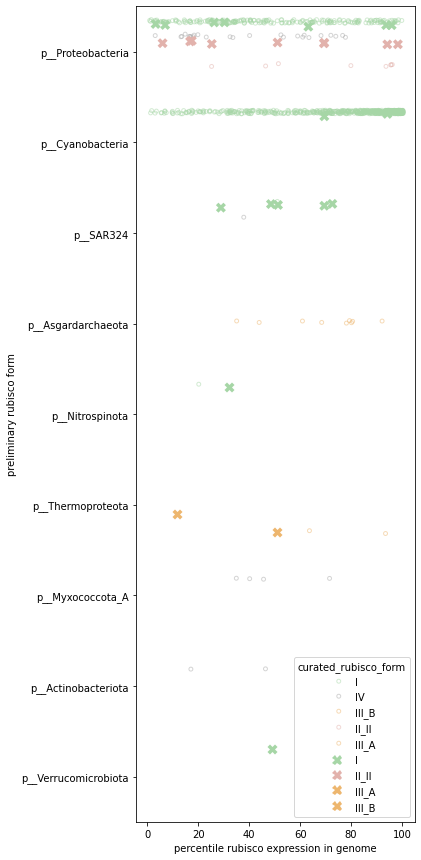

In [28]:
all_merge["phylum"] = all_merge["classification"].apply(lambda x: x.split(";")[1])

plt.figure(figsize=[5,15])
sns.stripplot(x="percentile",y="phylum", alpha=0.5, hue="curated_rubisco_form",
              palette=palette, size=7.5, dodge=True,
              data=all_merge[(all_merge["breadth"]>=0.50) &
                             (~all_merge["sample"].isin(deep_samples))], marker="$\circ$")
sns.stripplot(x="percentile",y="phylum", alpha=1, hue="curated_rubisco_form",
              palette=palette, size=10, dodge=True,
              data=all_merge[(all_merge["breadth"]>=0.50) &
                             (all_merge["sample"].isin(deep_samples))], marker="X")
plt.ylabel("preliminary rubisco form")
plt.xlabel("percentile rubisco expression in genome")
plt.show()

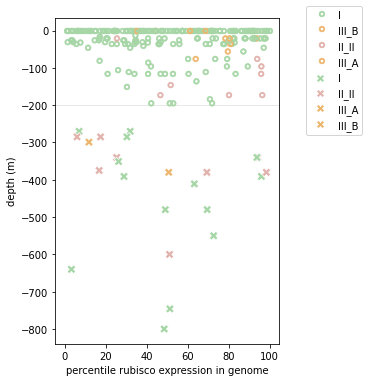

In [70]:
depth_fixes = {"TARA_SAMEA2623925_METAT": 25, "TARA_SAMEA2623974_METAT":25,
              "TARA_SAMEA2623808_METAT": 5, "TARA_SAMEA2623850_METAT": 5,
              "TARA_SAMEA2623734_METAT": 5, "TARA_SAMEA2620136_METAT": 25}
all_merge_depth = all_merge.merge(metat_md[["sample_name", "depth_numeric"]], 
                                  left_on="sample", right_on="sample_name", how="left").fillna("None")
all_merge_depth["depth_corrected"] = all_merge_depth.apply(lambda x: x["depth_numeric"] if \
                                    x["sample"] not in depth_fixes else depth_fixes[x["sample"]], axis=1)

display_data=all_merge_depth[(~all_merge_depth["classification"].str.contains("Cyano")) &
                             (all_merge_depth["depth_corrected"]!='None') & 
                             (all_merge_depth["breadth"]>0.50) & (all_merge["curated_rubisco_form"]!='IV')]
display_data["depth_negative"] = display_data["depth_corrected"].apply(lambda x: -1*x)

plt.figure(figsize=[4,6])
sns.scatterplot(x="percentile", y="depth_negative", hue="curated_rubisco_form",
               palette=palette, data=display_data.query("depth_negative>-200"), marker="$\circ$", ec="face", s=75)
sns.scatterplot(x="percentile", y="depth_negative", hue="curated_rubisco_form",
               palette=palette, data=display_data.query("depth_negative<=-200"), marker="X", s=75)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.axhline(-200, ls="-", zorder=0, linewidth=0.5,color="lightgrey")
plt.ylabel("depth (m)")
plt.xlabel("percentile rubisco expression in genome")
plt.savefig(rootdir + "figures/metat_perc_depth.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

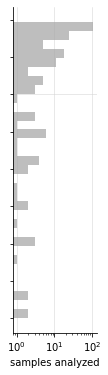

In [34]:
## sampling
plt.figure(figsize=[1.5,6])
metat_md["depth_negative"] = metat_md["depth_numeric"].apply(lambda x: x*-1)
ax = sns.histplot(y=metat_md["depth_negative"], bins=33, color="darkgrey", linewidth=0)
ax.set(yticklabels=[])
plt.xscale("log")

for k in [-200]:
    plt.axhline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")
for k in [1,10,100]:
    plt.axvline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")

plt.ylabel("")
plt.xlabel("samples analyzed")
sns.despine(top=True)
plt.savefig(rootdir + "figures/metat_sampling_long.pdf", format="pdf", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

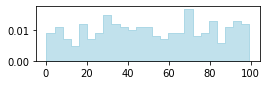

In [35]:
## histos
display_data=all_merge_depth[(~all_merge_depth["classification"].str.contains("Cyano")) &
                             (all_merge_depth["depth_corrected"]!='None') & 
                             (all_merge_depth["breadth"]>=0.50) & (all_merge["curated_rubisco_form"]!='IV')]
plt.figure(figsize=[4,1])
sns.histplot(x=display_data["percentile"],element="step", color="lightblue", stat="density", bins=25)
plt.xlabel("")
plt.ylabel("")
plt.savefig(rootdir + "figures/metat_all_histo.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

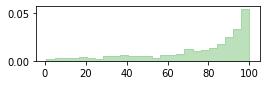

In [36]:
display_data=all_merge_depth[(all_merge_depth["classification"].str.contains("Cyano")) &
                             (all_merge_depth["depth_corrected"]!='None') & 
                             (all_merge_depth["breadth"]>=0.50) & (all_merge["curated_rubisco_form"]!='IV')]
plt.figure(figsize=[4,1])
sns.histplot(x=display_data["percentile"],element="step", color="#A6D6A6", stat="density", bins=25)
plt.xlabel("")
plt.ylabel("")
plt.savefig(rootdir + "figures/metat_cyano_histo.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

### add back functions

In [115]:
# split out functions when multiple hits
funcs_raw = pd.read_csv(rootdir + "tables/metabolic_gene_info.tsv", sep="\t")

funcs_info = defaultdict(list)

for key, row in funcs_raw.query("present==True").iterrows():
    
    for hit_id in row["hit_ids"].split(","):
        funcs_info["gene"].append(hit_id)
        funcs_info["curated_function"].append(row["gene"])
        funcs_info["curated_pathway"].append(row["function"])

funcs_df = pd.DataFrame(funcs_info)
amerge = rmerge.merge(funcs_df, how="left").fillna("None")
# then add back raw kofamscan for others
amerge = amerge.merge(pd.read_csv(rootdir + \
    "tables/nonredundant_kfscan_parsed.tsv", sep="\t")[["gene", "ko","def"]], how="left").fillna("None")
amerge = amerge.rename(columns={"ko": "raw_ko", "def": "raw_ko_def"})
amerge.head(2)

,Unnamed: 0,sample,genome,gene,mean_coverage,breadth,read_count,gene_length,total_read_count,rpk,rpkm,curated_rubisco_form,classification,curated_function,curated_pathway,raw_ko,raw_ko_def
0,306706,TARA_SAMEA2623830_METAT,AG-333-E20,CABYJX010000001.1_1,0.05,0.053680,1,1155,315435310,1.731602,0.005490,None,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,None,None,K17724,aconitate decarboxylase [EC:4.1.1.6]
1,306707,TARA_SAMEA2623830_METAT,AG-333-E20,CABYJX010000001.1_2,0.42,0.230159,3,882,315435310,6.802721,0.021566,None,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,None,None,K01644,citrate lyase subunit beta / citryl-CoA lyase ...


In [116]:
def reconcile_functions(row):
    
    if "III" in row["curated_rubisco_form"]:
        return "form III rubisco"
    elif row["curated_rubisco_form"] not in ["None", "IV"]:
        return "form %s rubisco" %(row["curated_rubisco_form"].split("_")[0])
    elif "sulf" in row["curated_pathway"].lower():
        return "sulfur metabolism"
    elif "calvin" in row["curated_pathway"]:
        return "calvin cycle"
    elif row["curated_pathway"] == "Aerobic Hydrogen Oxidation":
        return "uptake hydrogenase"
    elif "subunit ribosomal protein" in row["raw_ko_def"]:
        return "ribosomal proteins"
    else: return "other"

amerge["reconciled_function"] = amerge.apply(reconcile_functions, axis=1)

In [201]:
clean = amerge[["sample", "genome", "gene", "rpkm", "breadth", "curated_pathway", "reconciled_function", "raw_ko", "raw_ko_def"]]
clean["reconciled_function"].value_counts()

reconciled_function
other                 10313432
ribosomal proteins      212790
calvin cycle             40835
sulfur metabolism         8895
form I rubisco            3661
uptake hydrogenase         330
form II rubisco            141
form III rubisco            37
Name: count, dtype: int64

### genome based

In [118]:
shorthand = {row["sample_name"]:"%s (%d m)" %(row["biosample"], row["depth_numeric"]) for \
            key, row in metat_md.iterrows()}

In [121]:
def make_txome_plot(genomes, samples=clean["sample"].unique()):
    
    palette = {"form I rubisco": "green", "form II rubisco":"pink", "form III rubisco": "orange",
               "calvin cycle": "lightgreen", "uptake hydrogenase": "blue", "sulfur metabolism": "yellow", 
               "ribosomal proteins": "lightblue", "other":"lightgrey"}

    table = clean[(clean["genome"].isin(genomes)) & \
                  (clean["sample"].isin(samples))]
    table["log_rpkm"] = table["rpkm"].apply(lambda x: math.log10(x+1))
    sort_base = all_merge[(all_merge["genome"].isin(genomes)) & \
                  (all_merge["sample"].isin(samples))].sort_values("rpkm")
    table["sort_order"] = table["sample"].apply(lambda x: list(sort_base["sample"]).index(x))
    table["sample_short"] = table["sample"].map(shorthand)
    table = table.sort_values("sort_order")

    plt.figure(figsize=[2,1*max(len(genomes), len(table["sample"].unique()))])
    
    if len(genomes) > 1:
        facetvar = "genome"
        title = samples[0]
    else: 
        facetvar = "sample_short"
        title = genomes[0]
        
    sns.stripplot(y=facetvar, x="log_rpkm", data=table.query("reconciled_function=='other'"), 
                  hue="reconciled_function", palette=palette, alpha=0.5, marker="$\circ$")
    sns.stripplot(y=facetvar, x="log_rpkm", data=table.query("reconciled_function!='other'"), 
                  hue="reconciled_function", palette=palette, alpha=1, dodge=True)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
    plt.xlabel("expression (log rpkm+1)")
    #plt.title(title)
    plt.ylabel("")
    #plt.xticks(rotation=45, ha="right")

<Figure size 432x288 with 0 Axes>

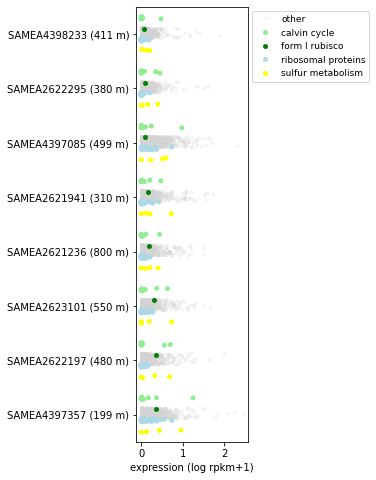

In [122]:
plt.figure()
make_txome_plot(genomes=["BGEO_SAMN07136798_METAG_LAMHFHAM"],
                              samples=["TARA_SAMEA4397085_METAT","TARA_SAMEA2622295_METAT", 
                                       "TARA_SAMEA4398233_METAT","TARA_SAMEA2621941_METAT",
                                      "TARA_SAMEA2623101_METAT","TARA_SAMEA2622197_METAT", 
                                       "TARA_SAMEA4397357_METAT", "TARA_SAMEA2621236_METAT"])
plt.savefig(rootdir + "figures/sar324_genome_metat_1.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

### supp

In [188]:
table_s10 = all_merge_depth[(all_merge_depth["depth_corrected"]!='None') & 
    (all_merge["curated_rubisco_form"]!='IV')].merge(metat_md[["sample_name", "runs"]], 
     how="left", left_on="sample", right_on="sample_name").fillna("None")
table_s10["runs_corrected"] = table_s10.apply(lambda x: x["runs"] if x["runs"]!='None' else \
                                                omd_metadata[omd_metadata["sample_name"]==x["sample"]]["run_accessions"].iloc[0], axis=1)
table_s10["percentile_rubisco_expr"] = table_s10.apply(lambda x: x["percentile"] if x["breadth"]>=0.50 else "None", axis=1)
table_s10[["sample", "runs_corrected","depth_corrected", "genome", "classification", "gene", "curated_rubisco_form", "gene_length", 
           "mean_coverage", "read_count", "breadth", "total_read_count", "rpkm", 
           "percentile_rubisco_expr"]].sort_values(["sample", "mean_coverage"], ascending=[True,False]).to_csv(rootdir + "tables/table_s10.tsv", sep="\t", index=False)

In [215]:
picked = ["TARA_SAMEA4397085_METAT","TARA_SAMEA2622295_METAT", 
           "TARA_SAMEA4398233_METAT","TARA_SAMEA2621941_METAT",
          "TARA_SAMEA2623101_METAT","TARA_SAMEA2622197_METAT", 
           "TARA_SAMEA4397357_METAT", "TARA_SAMEA2621236_METAT"]
table_s11 = clean[(clean["genome"].str.contains("LAM")) & (clean["sample"].isin(picked))]
table_s11.query("reconciled_function!='other'")[["sample", "genome", "gene", "raw_ko_def", "reconciled_function",
                                                 "rpkm", "breadth"]].sort_values(["sample", "rpkm"], ascending=[True,False]).to_csv(rootdir + "tables/table_s11.tsv", sep="\t", index=False)